### Data 620 - Project 1
### Bikram Barua and Leticia Salazar
### February 19, 2023

#### Task: 

For your first project, you are asked to:
1. Identify and load a network dataset that has some categorical information available for each node.
2. For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
3. Compare your centrality measures across your categorical groups.

For example, using the dataset from a study of romantic relationships among high school students in Columbus, Ohio [http://researchnews.osu.edu/archive/chains.htm], you might want to determine if there are any differences in your calculated centrality measures between the two sexes.  You might use a t-test or another statistical measure to support your findings.

#### Data source:

The dataset selected for project 1 was obtained from [Network Repository](https://networkrepository.com/socfb-Cornell5.php) consisting of people (nodes) and their friendship ties (edges) on Facebook. The data is available in a matrix market, typically a sparse format used to represent a matrix (.mtx file). With these types of files, the first line contains a header with information about the matrix, dimensions, and symmetry of the matrix. The following lines are non-zero entries of the matrix in row-major order, with each following line containing the row index, column index, and a value of a single non-zero entry.

Below are some specs from this dataset provided by the repository:

* Nodes: 18.7K
* Edges: 790.8K
* Density: 0.00454239
* Maximum degree: 3.2K
* Minimum degree: 1
* Average degree: 84
* Assortativity: 0.01805
* Number of triangles: 18.3M
* Average number of triangles: 982
* Maximum number of triangles: 77.2K
* Average clustering coefficient: 0.219051
* Fraction of closed triangles: 0.135615
* Maximum k-core: 85
* Lower bound of Maximum Clique: 13

#### Objectives: 

We will be focusing to answer the following while we explore, analyze and create visualizations for our data.

* Which centrality measure would be the most relevant in the dataset?
* What would these centrality measures help us to predict?
* What statistical tests can we apply to identify the best fit centrality measure?

#### Load libraries:

Below are the libraries used

In [1]:
# data manipulation
import pandas as pd
import numpy as np
import scipy.io #for mtx files
from tqdm import tqdm #Instantly make your loops show a smart progress meter 
import random 
from scipy import stats

# data visualization
import networkx as nx
import matplotlib.pyplot as plt
from networkx_viewer import Viewer

#### Load the data:
Data exploration of the data is performed below to view the size of the datasets we will be working with. As mentioned, the original file had to be converted to a csv file for us to work with the dataset.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/letisalba/Data-620/master/Week-4/fb-cornell5.csv', header = None)
# rename column headers
df.columns = ["People", "Friendships"]
print(df.head(10))

   People  Friendships
0     184            1
1     344            1
2     635            1
3     867            1
4    1296            1
5    1358            1
6    1425            1
7    1501            1
8    1505            1
9    1845            1


#### Create NetworkX Graph

In [3]:
# start networkX 
G = nx.Graph()
G.add_nodes_from(df)

for i, elrow in df.iterrows():
    G.add_node(elrow[0])
    G.add_node(elrow[1])

    if G.has_edge(elrow[0], elrow[1]):
            # edge already exists, increase weight by one
            G[elrow[0]][elrow[1]]['weight'] += 1
    else:
            # add new edge with weight 1
            G.add_edge(elrow[0], elrow[1], weight = 1)


G_nodes = G.number_of_nodes()
G_edges = G.number_of_edges()
print("The number of nodes = ", G_nodes, " The number of edges = ", G_edges)

The number of nodes =  18662  The number of edges =  790776


In [4]:
# Preview first 5 edges

list(G.edges(data=True))[0:5]

[(184, 1, {'weight': 1}),
 (184, 5, {'weight': 1}),
 (184, 136, {'weight': 1}),
 (184, 226, {'weight': 1}),
 (184, 519, {'weight': 1})]

In [5]:
# Preview first 10 nodes

list(G.nodes(data=True))[0:10]

[('People', {}),
 ('Friendships', {}),
 (184, {}),
 (1, {}),
 (344, {}),
 (635, {}),
 (867, {}),
 (1296, {}),
 (1358, {}),
 (1425, {})]

#### Calculating degree and eigenvector centrality for the dataset.

For both degree and eigenvector centrality, we created a column for the calculations to have their own column and then merged these columns into our dataset separately.

In [6]:
# degree centrality
degree = nx.degree(G)
df_2 = pd.DataFrame(degree, columns = ['People','Degree_Cent'])
df_2 = pd.merge(df_2, df, on='People', how='inner')
df2 = df_2.sort_values('Degree_Cent', ascending = False)
df2.head()

,People,Degree_Cent,Friendships
105721,17027,3156,337
107116,17027,3156,8614
107136,17027,3156,8723
107135,17027,3156,8712
107134,17027,3156,8711


In [7]:
df2.tail()

,People,Degree_Cent,Friendships
757617,8916,1,789
790115,10051,1,5082
790537,9224,1,7670
788694,3833,1,3036
790775,18575,1,16538


In [8]:
# eigenvector centrality
eigen = nx.eigenvector_centrality(G)
df_3 = pd.DataFrame.from_dict(eigen, orient='index').reset_index()
df_3.columns = ['People', 'Eigenvec_Cent']
df_3 = pd.merge(df_3, df, on='People', how='inner')
df_3 = df_3.sort_values('Eigenvec_Cent', ascending = False)
df_3.head()

,People,Eigenvec_Cent,Friendships
3024,9651,0.117948,4057
2436,9651,0.117948,245
2427,9651,0.117948,199
2428,9651,0.117948,204
2429,9651,0.117948,219


In [9]:
df_3.tail()

,People,Eigenvec_Cent,Friendships
789851,17058,3.558682e-58,4320
790752,15288,3.558682e-58,13467
790725,13542,3.558682e-58,11936
786310,3671,3.558682e-58,2127
789174,8416,3.558682e-58,3473


#### Visualize our data

In an example from [DataCamp](https://www.datacamp.com/tutorial/social-network-analysis-python) they read from a text file, which we used as reference and converted our data into a text file. Since our original dataset is a large file we split the data to ensure that the visualizations don't take too long to be produced.

In [10]:
#fb = nx.read_edgelist("facebook_comb_split1.txt", create_using = nx.Graph(), nodetype=int)
#print(nx.info(fb))

fb = nx.read_edgelist("facebook_comb_split2.txt", create_using = nx.Graph(), nodetype=int)
print(nx.info(fb))

Graph with 11345 nodes and 27000 edges


/var/folders/xs/s7qlj6l16qj7704tpbyx6rr80000gn/T/ipykernel_30327/762229073.py:5: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(fb))


#### Now for our graphs

Betweeness Centrality: measures the number of times a node lies on the shortest path between other nodes. This measure shows which nodes are ‘bridges’ between nodes in a network. It does this by identifying all the shortest paths and then counting how many times each node falls on one.

[17027, 94, 50, 9651, 154]

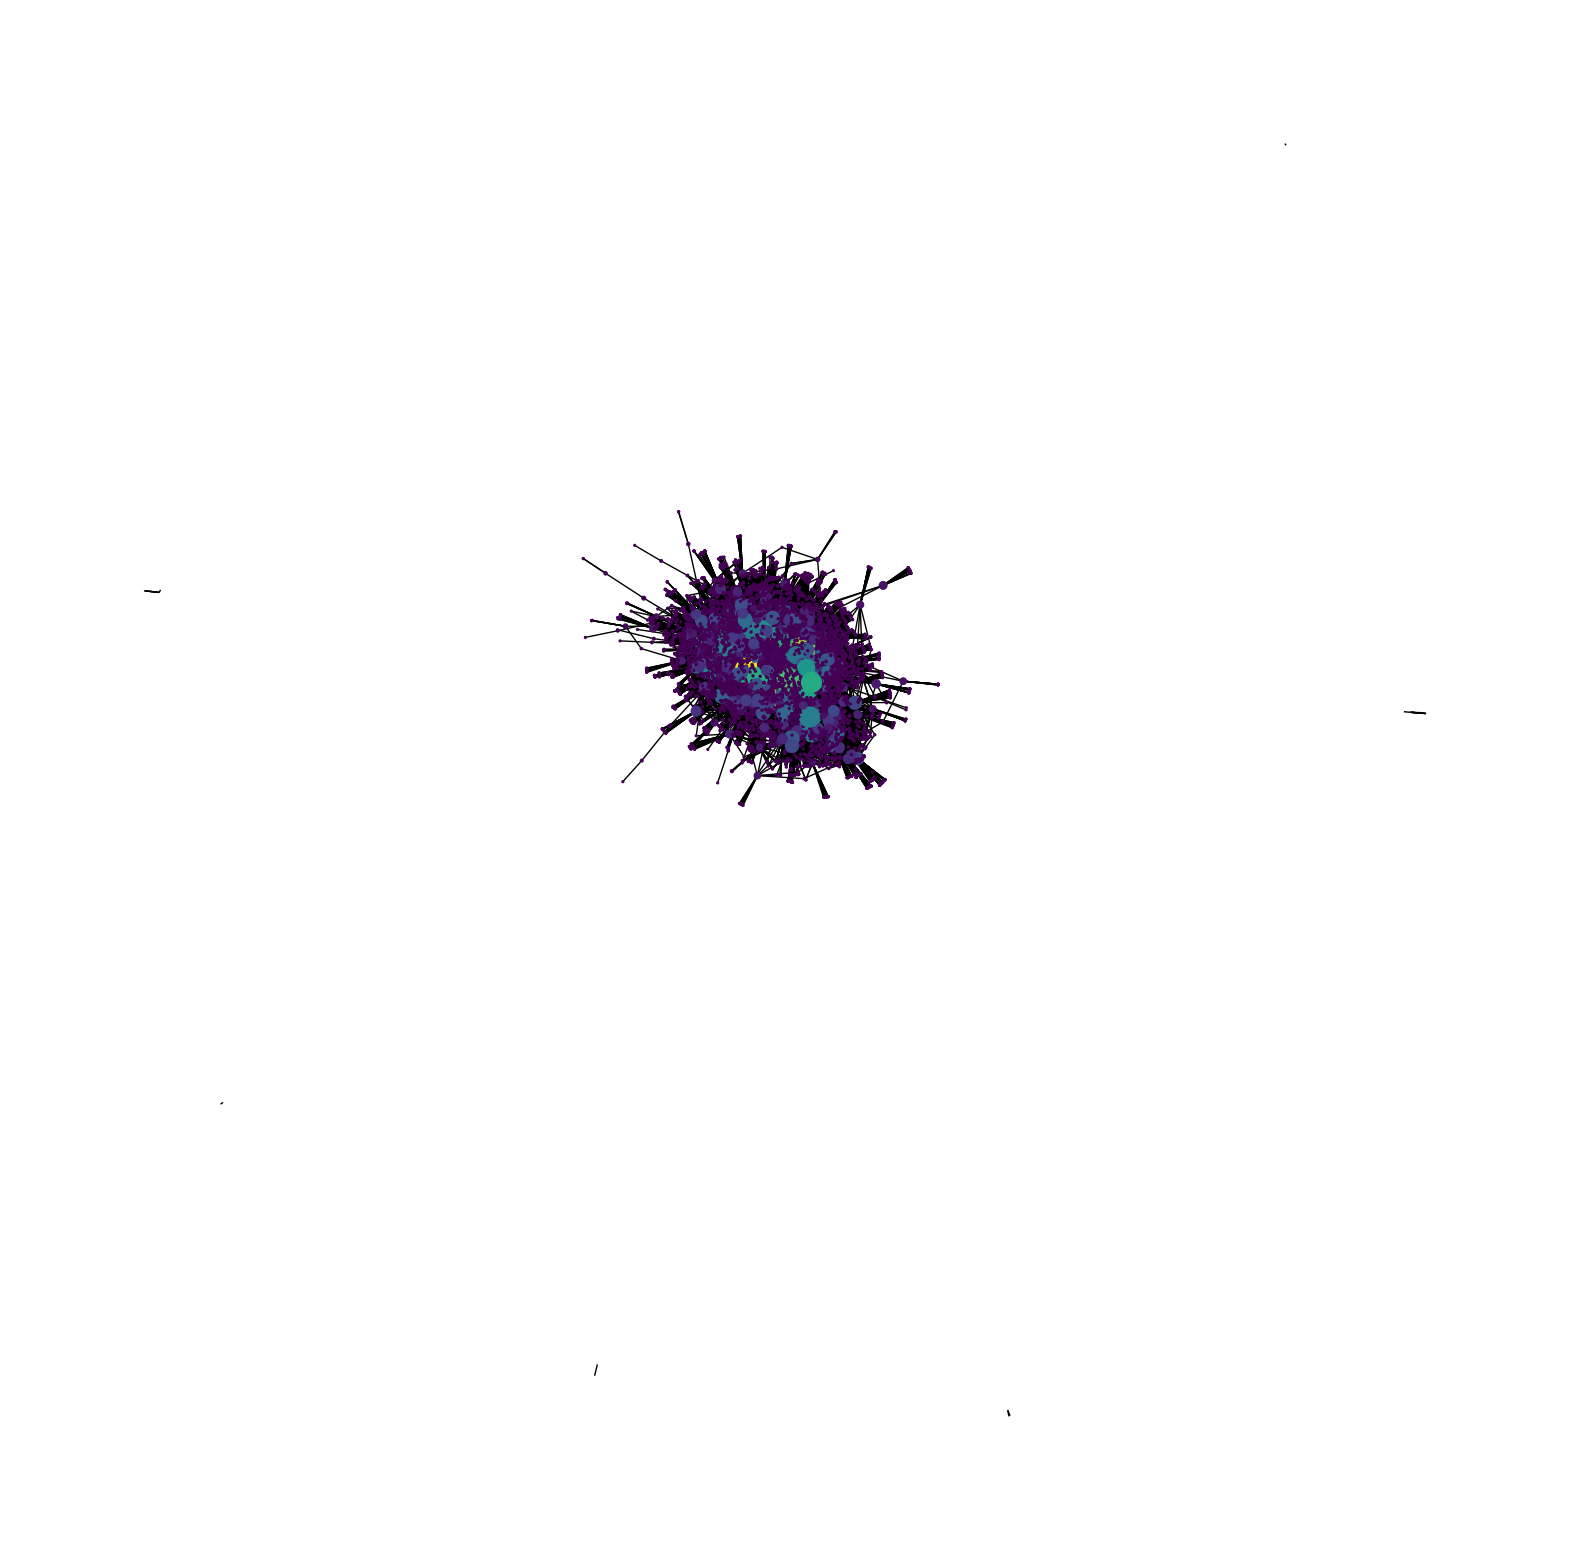

In [11]:
# Graph betweeness centrality
pos = nx.spring_layout(fb)
bc = nx.betweenness_centrality(fb, normalized=True, endpoints=True)
node_color = [20000.0 * fb.degree(v) for v in fb]
node_size =  [v * 10000 for v in bc.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(fb, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

# labels of nodes with the highest betweeness centrality
sorted(bc, key=bc.get, reverse=True)[:5]

Closeness Centrality: scores each node based on their ‘closeness’ to all other nodes in the network. This measure calculates the shortest paths between all nodes, then assigns each node a score based on its sum of shortest paths.

[17027, 9651, 154, 94, 180]

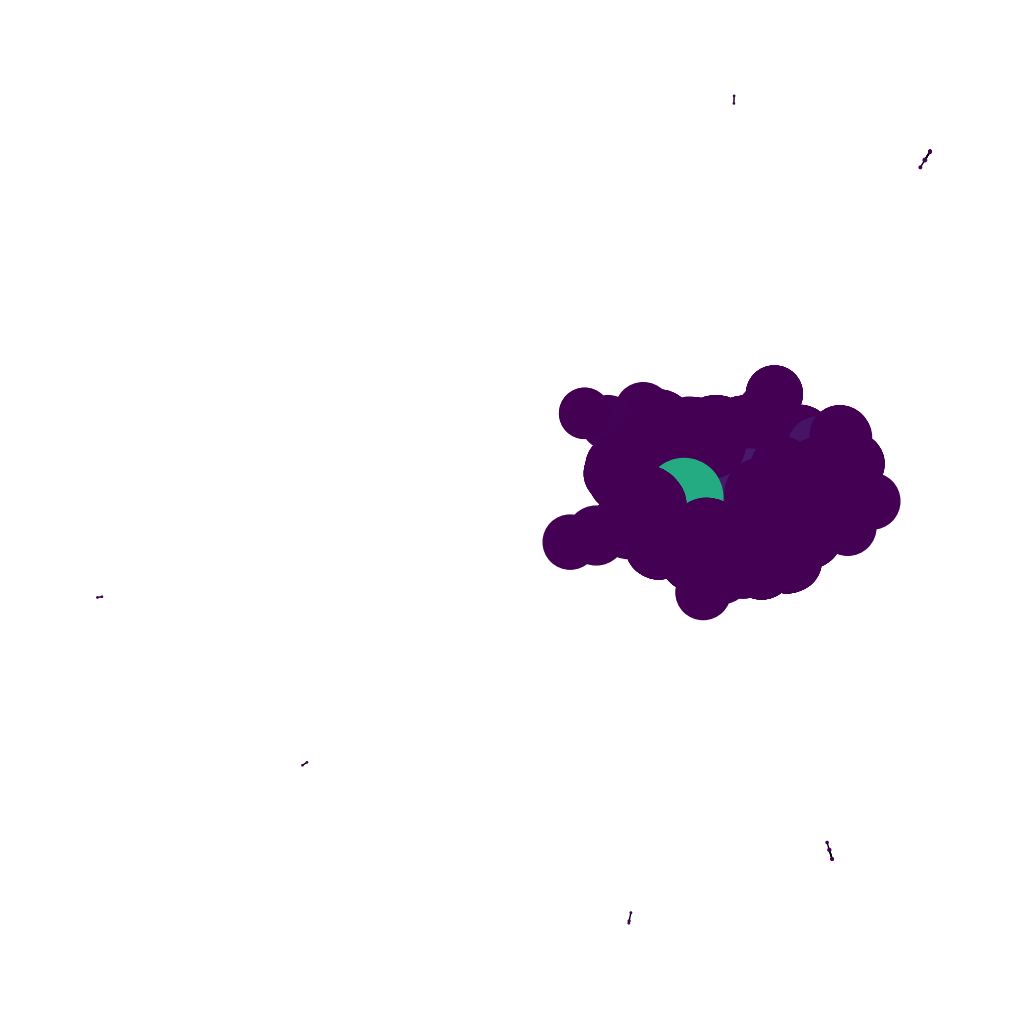

In [12]:
# Graph closeness centrality
pos = nx.spring_layout(fb)
cc = nx.closeness_centrality(fb)
node_color = [20000.0 * fb.degree(v) for v in fb]
node_size =  [v * 10000 for v in cc.values()]
plt.figure(figsize=(13,13))
nx.draw_networkx(fb, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

# labels of nodes with the highest closeness centrality
sorted(cc, key=cc.get, reverse=True)[:5]

Degree Centrality: assigns an importance score based simply on the number of links held by each node. This tells us how many direct, ‘one hop’ connections each node has to other nodes in the network.

[94, 50, 289, 107, 180]

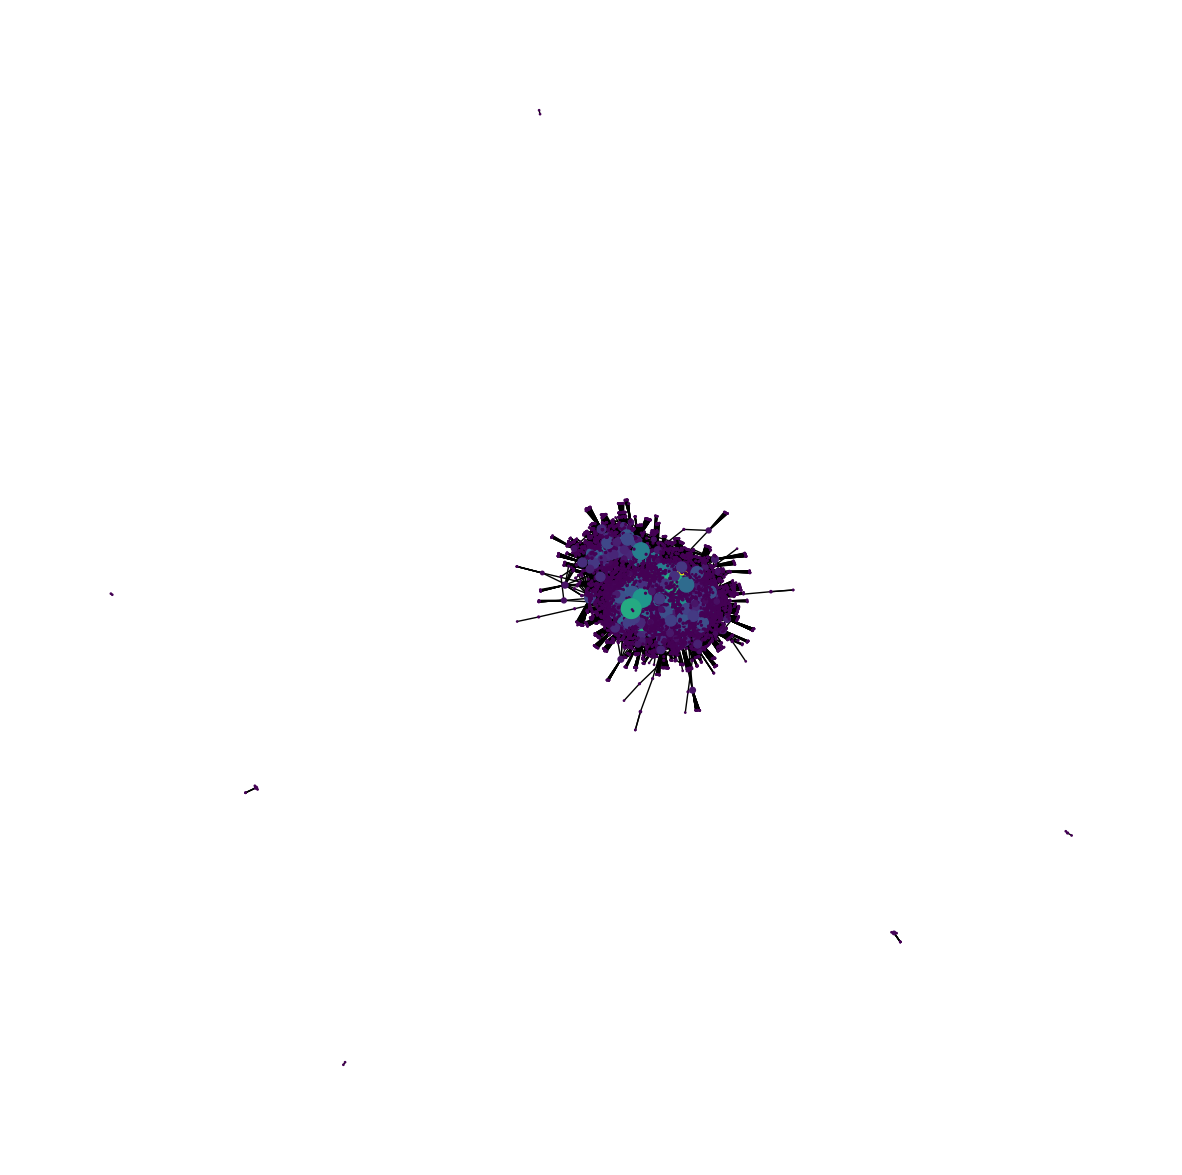

In [13]:
# Graph degree centrality
pos = nx.spring_layout(fb)
dc = nx.degree_centrality(fb)
node_color = [20000.0 * fb.degree(v) for v in fb]
node_size =  [v * 10000 for v in dc.values()]
plt.figure(figsize=(15,15))
nx.draw_networkx(fb, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

# labels of nodes with the highest degree centrality
sorted(dc, key=dc.get, reverse=True)[:5]

Eigenvector Centrality: measures a node’s influence based on the number of links it has to other nodes in the network. EigenCentrality then goes a step further by also taking into account how well connected a node is, and how many links their connections have, and so on through the network. By calculating the extended connections of a node, EigenCentrality can identify nodes with influence over the whole network, not just those directly connected to it.

[50, 289, 69, 307, 94]

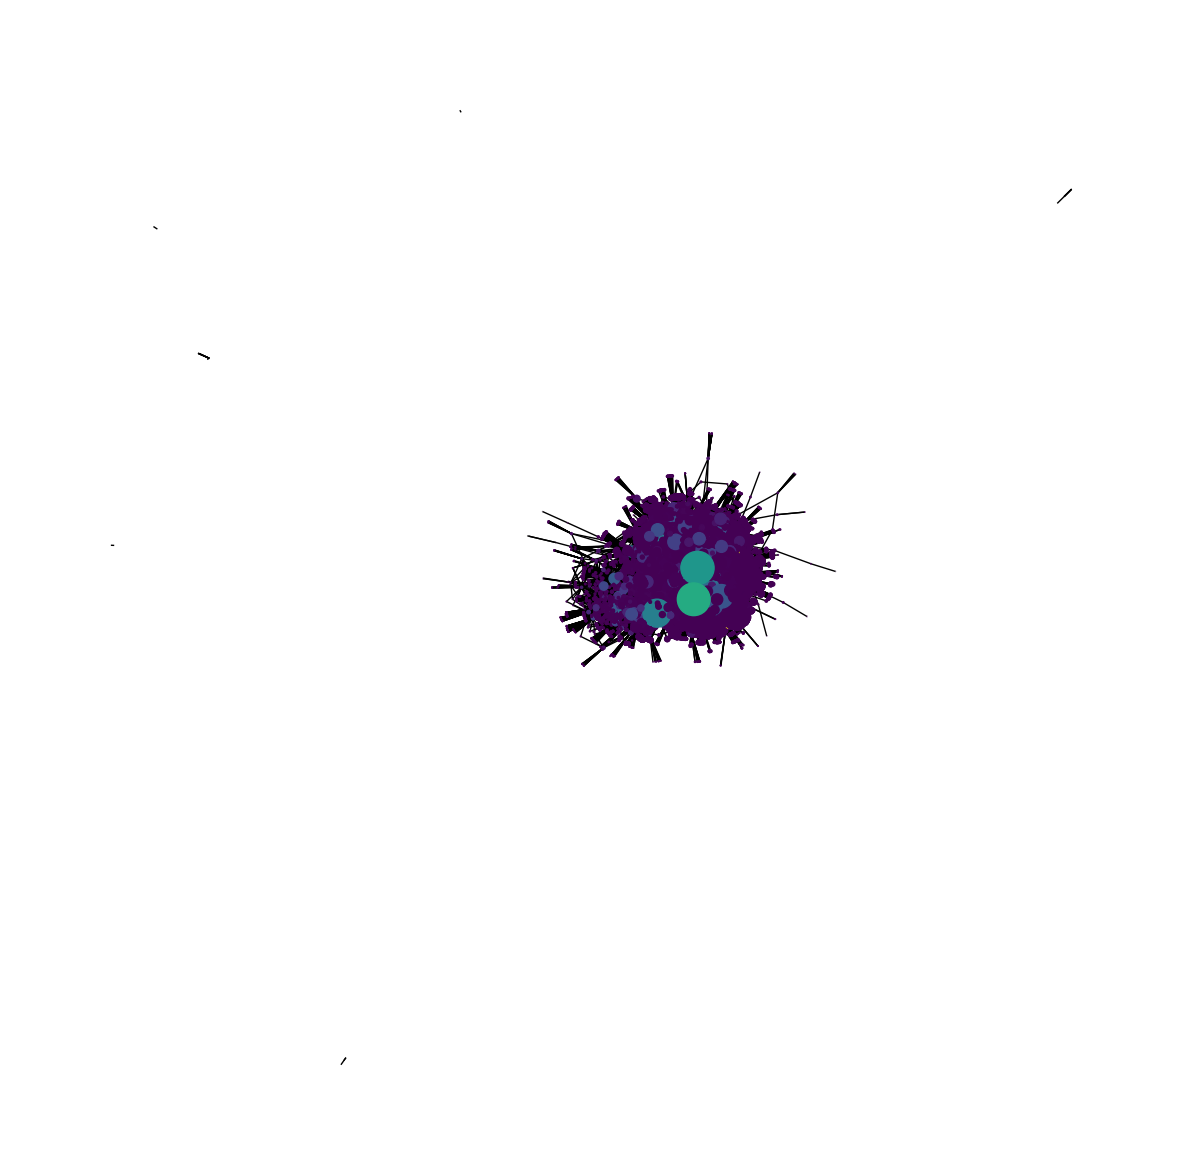

In [14]:
# Graph eigenvector centrality
pos = nx.spring_layout(fb)
ec = nx.eigenvector_centrality(fb)
node_color = [20000.0 * fb.degree(v) for v in fb]
node_size =  [v * 10000 for v in ec.values()]
plt.figure(figsize=(15,15))
nx.draw_networkx(fb, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

# labels of nodes with the highest eigenvector centrality
sorted(ec, key=ec.get, reverse=True)[:5]

In [15]:
# Count degree nodes
d = dict(fb.degree()).values()
from collections import Counter
Counter(d)

Counter({167: 1,
         104: 2,
         5: 567,
         3: 1586,
         1: 4473,
         4: 977,
         2: 2732,
         15: 3,
         8: 111,
         6: 309,
         9: 53,
         10: 29,
         7: 175,
         60: 5,
         14: 10,
         12: 12,
         58: 3,
         13: 7,
         70: 3,
         157: 2,
         74: 4,
         88: 3,
         248: 1,
         153: 1,
         148: 2,
         142: 2,
         11: 17,
         225: 2,
         93: 2,
         228: 2,
         150: 1,
         324: 1,
         55: 2,
         16: 4,
         29: 2,
         38: 4,
         57: 3,
         158: 3,
         163: 1,
         71: 2,
         208: 2,
         62: 6,
         105: 3,
         204: 2,
         152: 1,
         133: 3,
         141: 2,
         179: 1,
         111: 1,
         161: 1,
         32: 3,
         47: 5,
         36: 3,
         53: 2,
         28: 3,
         66: 2,
         115: 2,
         50: 1,
         23: 2,
         20: 2,
  

In [16]:
max(x for x,y in nx.degree(fb))

18659

In [17]:
# New split data into csv file (same criteria as facebook_comb_split1.txt)
fb_df = pd.read_csv('https://raw.githubusercontent.com/letisalba/Data-620/master/Week-5/fb.csv')
print(fb_df.head(10))

   People  Friendships
0     184            1
1     344            1
2     635            1
3     867            1
4    1296            1
5    1358            1
6    1425            1
7    1501            1
8    1505            1
9    1845            1


#### T-Test:

Performing a statistical test on the split data.

In [18]:
# Performing T-Test
p1 = fb_df["People"]
f1 = fb_df["Friendships"]

t_value,p_value= stats.ttest_ind(p1.values,f1.values)

t_value

287.28512496457023

In [19]:
p_value

0.0

#### Conclusion:

Now to answer our objective questions:

* Which centrality measure would be the most relevant in the dataset?

Due to the large dataset we obtained and even with it being splitting up, we weren't able to obtain a clear visualization of the connection within the People and their Friendships.

* What would these centrality measures help us to predict?

Ideally in social networks these centrality measures can help predict who is a leader, influencer or a connector among this group as well as those individuals who are isolated or excluded. 

* What statistical tests can we apply to identify the best fit centrality measure?

We attempted to perform a T-test on the split data first but the result weren't clear to our understanding. We decided to disregard the test and not continue finding the best fit centrality. 

#### References:

* Kapoor, A. (2018, October 2). Social network analysis &amp; mapping in python with NetworkX. DataCamp. Retrieved February 25, 2023, from https://www.datacamp.com/tutorial/social-network-analysis-python 
* Rossi, R. A., & Ahmed, N. K. (2015). The Network Data Repository with Interactive Graph Analytics and Visualization. Network Data Repository. Retrieved February 16, 2023, from https://networkrepository.com 
* AOMAR, A. A. I. T. (2020, August 2). Notes on graph theory - centrality measures. Medium. Retrieved February 17, 2023, from https://towardsdatascience.com/notes-on-graph-theory-centrality-measurements-e37d2e49550a 
* Disney, A. (2022, October 27). Social network analysis: Understanding centrality measures. Cambridge Intelligence. Retrieved February 18, 2023, from https://cambridge-intelligence.com/keylines-faqs-social-network-analysis/ 
* ArijitGayen@ArijitGayen. (2019, November 21). Network centrality measures in a graph using Networkx: Python. GeeksforGeeks. Retrieved February 18, 2023, from https://www.geeksforgeeks.org/network-centrality-measures-in-a-graph-using-networkx-python/ 
* Disney, A. (2022, October 27). Social network analysis: Understanding centrality measures. Cambridge Intelligence. Retrieved February 25, 2023, from https://cambridge-intelligence.com/keylines-faqs-social-network-analysis/#:~:text=Definition%3A%20Betweenness%20centrality%20measures%20the,each%20node%20falls%20on%20one. 